# Kaggle Plot

## Import

In [1]:
import os
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import ast
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import time

## Set Random Seed

In [2]:
def set_all_seeds(RANDOM_SEED):
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
seed = 1
set_all_seeds(seed)

## Data Processing

In [3]:
# get data
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

# comcat train and test data for data process
test_data['price'] = -1
train_data = pd.concat([train_data, test_data], axis=0)

# initial removal of unwanted features
drop_columns = ['id','scrape_id','last_scraped','picture_url','host_id','host_name','name']
train_data = train_data.drop(drop_columns, axis=1)

# avoid err in xgboost
train_data['host_verifications'] = train_data['host_verifications'].str.replace('[', '(')
train_data['host_verifications'] = train_data['host_verifications'].str.replace(']', ')')

# deal with incomplete data
categorical_columns_with_nans = ['host_is_superhost', 'bathrooms_text']
imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_columns_with_nans] = imputer.fit_transform(train_data[categorical_columns_with_nans])

beds_imputer = SimpleImputer(strategy='median')
train_data['beds'] = beds_imputer.fit_transform(train_data[['beds']])

train_data['description'] = train_data['description'].fillna('')

# add feature description_length
train_data['description_length'] = train_data['description'].apply(len)
train_data = train_data.drop('description', axis=1)

# onehot encode
categorical_columns = train_data.select_dtypes(include=['object']).columns
categorical_columns_to_encode = [col for col in categorical_columns if len(train_data[col].unique()) <= 20]
train_data = pd.get_dummies(train_data, columns=categorical_columns_to_encode, drop_first=True)

# add feature amenities_count
train_data['amenities_count'] = train_data['amenities'].apply(lambda x: len(x.split(',')))

# only keep year info of host_since
train_data['host_since'] = pd.to_datetime(train_data['host_since'])
train_data['host_since'] = train_data['host_since'].dt.year + train_data['host_since'].dt.month / 12
train_data['host_since'] = train_data['host_since'].astype('float64')

# extract numbers from bathrooms_text
train_data['bathrooms_text'] = train_data['bathrooms_text'].replace(to_replace='half', value='0.5', regex=True)
train_data['bathrooms_text'] = train_data['bathrooms_text'].replace(to_replace='Half', value='0.5', regex=True)
train_data['bathrooms_text'] = train_data['bathrooms_text'].str.extract('(\d+\.?\d*)').astype('float64')
train_data['bathrooms_text'] = train_data['bathrooms_text'].fillna(train_data['bathrooms_text'].mean())

x = train_data.drop(['price','property_type','neighbourhood_cleansed', 'amenities'], axis=1)
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
gmm = GaussianMixture(n_components=6, covariance_type='full', init_params='kmeans', random_state=seed).fit(x)
train_data['gmm_cluster'] = gmm.predict(x)

train_data = pd.get_dummies(train_data, columns=['property_type','neighbourhood_cleansed'], drop_first=True)

# advance drop cols
train_data = train_data.drop(['minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights',
                              'minimum_maximum_nights','maximum_maximum_nights','availability_60','availability_90',
                              'number_of_reviews_ltm','number_of_reviews_l30d'], axis=1)

# split test and train data
test_data = train_data[train_data['price'] == -1].drop(columns=['price'])
train_data = train_data[train_data['price'] != -1]

# deal with amenities
amenities_cols = ['Lock on bedroom door', 'Indoor fireplace', 'Dishwasher', 'BBQ grill', 'Barbecue utensils', 'Fire pit',
                  'Outdoor dining area', 'Sun loungers', 'Outdoor furniture', 'Private patio or balcony', 'Private backyard – Fully fenced', 'Pool']

for i in amenities_cols: 
    train_data[i] = 0
for i in train_data.index:
    for item in amenities_cols:
        if item in ast.literal_eval(train_data.loc[i, 'amenities']):
            train_data.loc[i, item] = 1
train_data = train_data.drop(['amenities'], axis=1)

for i in amenities_cols: 
    test_data[i] = 0
for i in test_data.index:
    for item in amenities_cols:
        if item in ast.literal_eval(test_data.loc[i, 'amenities']):
            test_data.loc[i, item] = 1
test_data = test_data.drop(['amenities'], axis=1)

## Plot function

In [10]:
def plotFunc(h, r, name):
    plt.figure(figsize=(6, 4))
    plt.plot(h, r, marker='o')
    plt.xticks(h)
    plt.title(name + ' vs Accuracy')
    plt.xlabel(name)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

## Plot RF Hyperparameter

### n_estimators

In [11]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
res = []
for i in hyperparam:
    rf = RandomForestClassifier(max_depth=None, n_estimators=i, n_jobs=-1, class_weight='balanced_subsample', 
                                min_samples_leaf=1, min_samples_split=2, random_state=seed)
    
    rf.fit(x_train, y_train)
    y_test_pred = rf.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'n_estimators')

### max_depth

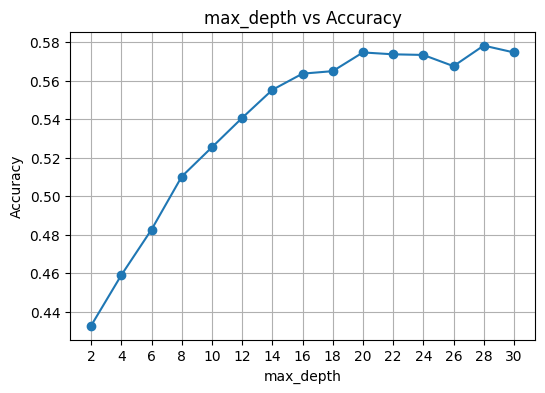

In [13]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
res = []
for i in hyperparam:
    rf = RandomForestClassifier(max_depth=i, n_estimators=900, n_jobs=-1, class_weight='balanced_subsample', 
                                min_samples_leaf=1, min_samples_split=2, random_state=seed)
    
    rf.fit(x_train, y_train)
    y_test_pred = rf.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'max_depth')

### min_samples_leaf

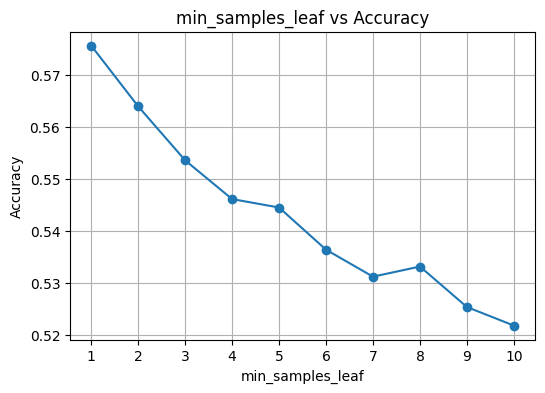

In [14]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
res = []
for i in hyperparam:
    rf = RandomForestClassifier(max_depth=None, n_estimators=900, n_jobs=-1, class_weight='balanced_subsample', 
                                min_samples_leaf=i, min_samples_split=2, random_state=seed)
    
    rf.fit(x_train, y_train)
    y_test_pred = rf.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'min_samples_leaf')

### min_samples_split

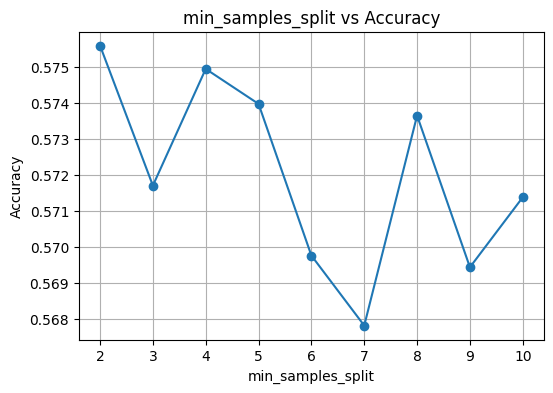

In [15]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [2, 3, 4, 5, 6, 7, 8, 9, 10]
res = []
for i in hyperparam:
    rf = RandomForestClassifier(max_depth=None, n_estimators=900, n_jobs=-1, class_weight='balanced_subsample', 
                                min_samples_leaf=1, min_samples_split=i, random_state=seed)
    
    rf.fit(x_train, y_train)
    y_test_pred = rf.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'min_samples_split')

## Plot Xgboost Hyperparameter

### max_depth

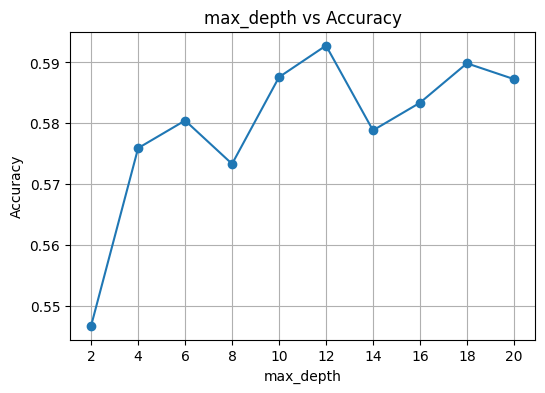

In [17]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=0.6, n_estimators=800, learning_rate=0.05, 
                            min_child_weight=0.4, max_depth=i, gamma=0.2, 
                            colsample_bylevel=0.8, colsample_bytree=0.6, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'max_depth')

### n_estimators

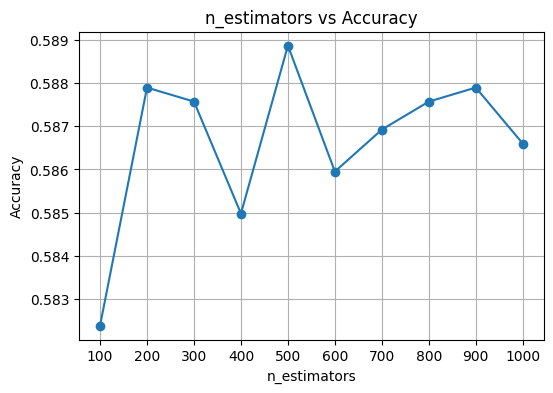

In [18]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=0.6, n_estimators=i, learning_rate=0.05, 
                            min_child_weight=0.4, max_depth=10, gamma=0.2, 
                            colsample_bylevel=0.8, colsample_bytree=0.6, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'n_estimators')

### learning_rate

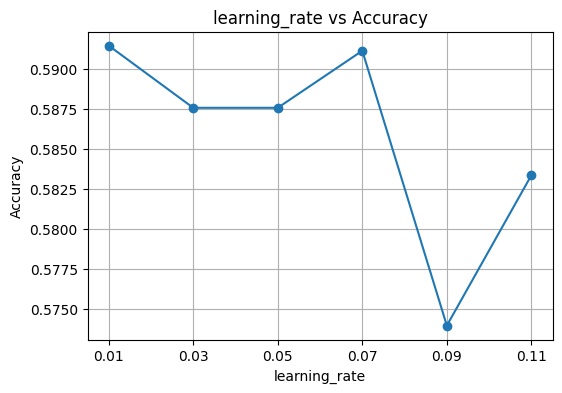

In [19]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=0.6, n_estimators=800, learning_rate=i, 
                            min_child_weight=0.4, max_depth=10, gamma=0.2, 
                            colsample_bylevel=0.8, colsample_bytree=0.6, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'learning_rate')

### min_child_weight

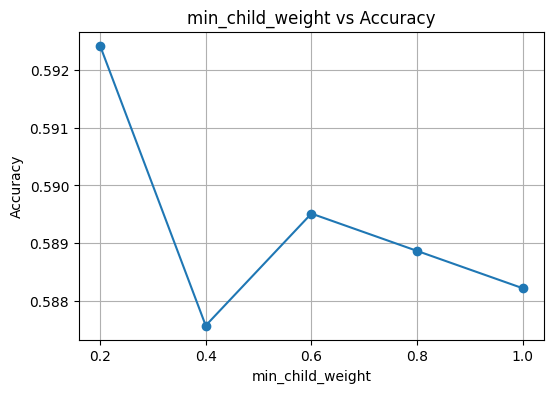

In [20]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [0.2, 0.4, 0.6, 0.8, 1]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=0.6, n_estimators=800, learning_rate=0.05, 
                            min_child_weight=i, max_depth=10, gamma=0.2, 
                            colsample_bylevel=0.8, colsample_bytree=0.6, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'min_child_weight')

### subsample

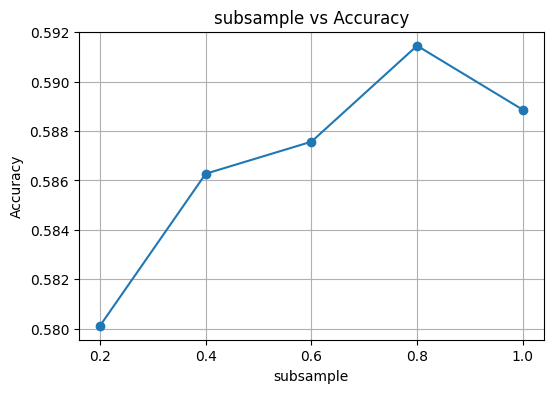

In [21]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [0.2, 0.4, 0.6, 0.8, 1]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=i, n_estimators=800, learning_rate=0.05, 
                            min_child_weight=0.4, max_depth=10, gamma=0.2, 
                            colsample_bylevel=0.8, colsample_bytree=0.6, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'subsample')

### gamma

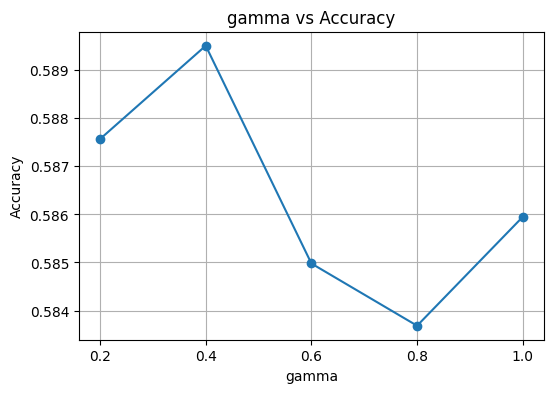

In [22]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [0.2, 0.4, 0.6, 0.8, 1]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=0.6, n_estimators=800, learning_rate=0.05, 
                            min_child_weight=0.4, max_depth=10, gamma=i, 
                            colsample_bylevel=0.8, colsample_bytree=0.6, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'gamma')

### colsample_bylevel

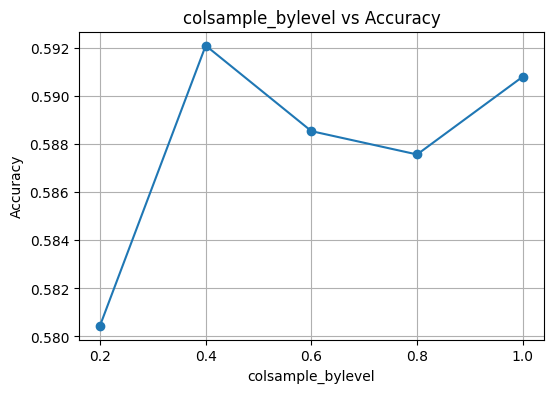

In [23]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [0.2, 0.4, 0.6, 0.8, 1]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=0.6, n_estimators=800, learning_rate=0.05, 
                            min_child_weight=0.4, max_depth=10, gamma=0.2, 
                            colsample_bylevel=i, colsample_bytree=0.6, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'colsample_bylevel')

### colsample_bytree

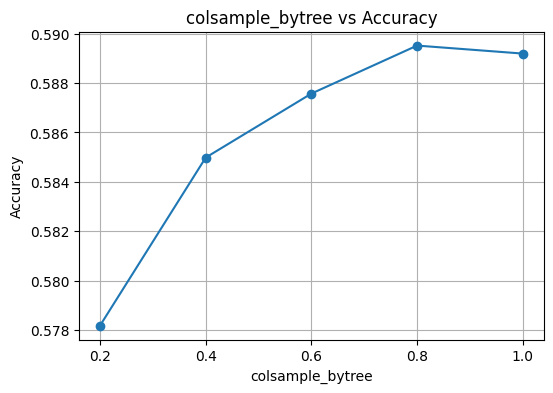

In [24]:
x = train_data.drop("price", axis=1)
y = train_data['price'].astype('int64')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

hyperparam = [0.2, 0.4, 0.6, 0.8, 1]
res = []
for i in hyperparam:
    xgboost = XGBClassifier(booster='gbtree', tree_method='auto', n_jobs=-1, 
                            subsample=0.6, n_estimators=800, learning_rate=0.05, 
                            min_child_weight=0.4, max_depth=10, gamma=0.2, 
                            colsample_bylevel=0.8, colsample_bytree=i, random_state=seed)

    xgboost.fit(x_train, y_train)
    y_test_pred = xgboost.predict(x_test)
    res.append(accuracy_score(y_test, y_test_pred))

plotFunc(hyperparam, res, 'colsample_bytree')